# Importing required packages and functions

In [1]:
import os
os.chdir('../')

import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from scvi.dataset import CortexDataset, RetinaDataset

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.metrics.differential_expression import get_statistics
from scvi.metrics.imputation import imputation
from scvi.metrics.visualization import show_t_sne

from scvi.models import VAE, SVAEC

from scvi.train import train, train_classifier

from scvi.utils import *

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ec2-user/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# load dataset 
Available datasets names and reference paper: 
* cortex: Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 
* cbmc: Stoeckius, Marlon, et al. "Simultaneous epitope and transcriptome measurement in single cells." nature methods 14.9 (2017): 865.
* brain_large: https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.3.0/1M_neurons
* retina: Shekhar, Karthik, et al. "Comprehensive classification of retinal bipolar neurons by single-cell transcriptomics." Cell 166.5 (2016): 1308-1323.
* synthetic: simulated zero-inflated negative binomial distribution with 2 batches, 200 cells per batch and 100 genes. 


In [2]:
gene_dataset = CortexDataset()

Preprocessing Cortex data


# Defining training parameters for the variational auto-encoder model

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA. 


In [3]:
n_epochs=500
lr=1e-3
use_batches=False
use_cuda=True

### Train the model and output model likelihood every 5 epochs

In [4]:
example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(0.9 * len(gene_dataset))  # 90%/10% train/test split

data_loader_train = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)
data_loader_test = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                              sampler=SubsetRandomSampler(example_indices[tt_split:]),
                              collate_fn=gene_dataset.collate_fn)
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches, n_labels=gene_dataset.n_labels,
            use_cuda=use_cuda)
stats = train(vae, data_loader_train, data_loader_test, n_epochs=n_epochs, lr=lr, benchmark=False)


Total runtime for 500 epochs is: 102.4199914932251 seconds for a mean per epoch runtime of 0.2048399829864502 seconds.


# Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error. 

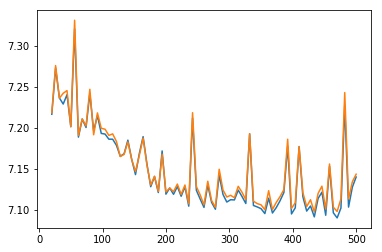

In [5]:
LL_train = stats.history["LL_train"]
LL_test = stats.history["LL_test"]
x = np.linspace(20,500,(len(LL_train)-19))
plt.plot(x, np.log(LL_train)[19:500])
plt.plot(x, np.log(LL_test)[19:500])
plt.show()



# Visualizing the latent space

In [6]:
data_loader = DataLoader(gene_dataset, batch_size=128, 
                         pin_memory=use_cuda,shuffle=False,
                         collate_fn = gene_dataset.collate_fn)

latent, batch_indices, labels = get_latent(vae,data_loader)

if latent.shape[1] != 2:
    latent = TSNE().fit_transform(latent)


In [7]:
cell_types = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons', 'microglia',
                       'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'], dtype=np.str)
colors = sns.color_palette("hls",len(cell_types) )

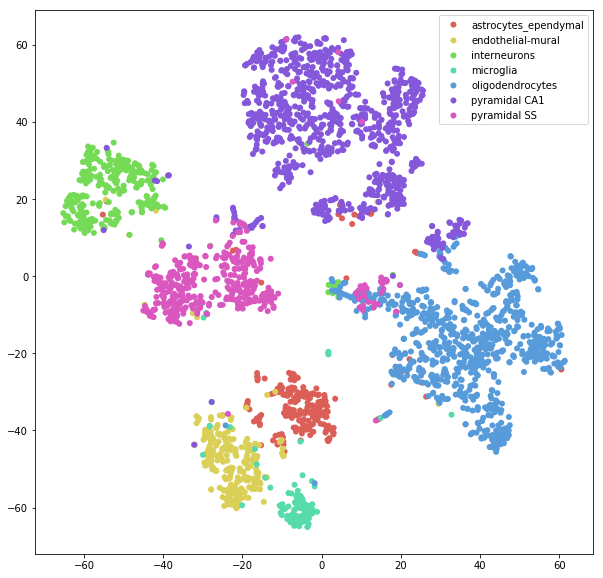

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(cell_types)):
    ax.scatter(latent[labels==i,0], latent[labels==i,1], c=colors[i], label=cell_types[i], edgecolors='none')

ax.legend()

plt.show()

# Checking imputation accuracy 
Parameters:
* The rate of simulated dropout is defined by __rate__, here set ot 0.3 

To check the imputation accuracy of the model, we iterate over each batch of input count matrix (n_sample\*n_genes), randomly induce dropouts by changing non-zero values in the matrix (__sample_batch__) to zero, and obtain the imputed value (__px_rate__) from the trained VAE model at those positions. We then plot the distribution of distance between the imputed value and the true value at the dropout positions. 

Note: The imputed value __px_rate__ is the rate parameter (expected value) of the Zero-Inflated Negative Binomial (ZINB) distribution.

In [9]:
rate = 0.3 
distance_list = torch.FloatTensor([])
for tensorlist in data_loader_train:
    tensorlist = to_cuda(tensorlist)
    sample_batch, local_l_mean, local_l_var, batch_index, labels = tensorlist
    sample_batch = sample_batch.type(torch.float32)
    dropout_batch = sample_batch.clone()
    indices = torch.nonzero(dropout_batch)
    i, j = indices[:, 0], indices[:, 1]
    ix = torch.LongTensor(np.random.choice(range(len(i)), int(np.floor(rate * len(i))), replace=False))
    dropout_batch[i[ix], j[ix]] *= 0

    if vae.use_cuda:
        ix, i, j = to_cuda([ix, i, j], async=False)
    px_rate = vae.get_sample_rate(dropout_batch, labels, batch_index=batch_index)
#     print(px_rate.shape)
#     distance_list = torch.cat([distance_list, torch.abs((px_rate[i[ix], j[ix]] - sample_batch[i[ix], j[ix]]) /sample_batch[i[ix], j[ix]]).cpu()])
    distance_list = torch.cat([distance_list, torch.abs(px_rate[i[ix], j[ix]] - sample_batch[i[ix], j[ix]]).cpu()])

(array([1.30000e+01, 8.00000e+01, 5.32000e+02, 4.08600e+03, 2.92750e+04,
        1.41103e+05, 1.34530e+05, 1.12520e+04, 7.52000e+02, 6.30000e+01]),
 array([-4.66841745, -3.81197968, -2.9555419 , -2.09910412, -1.24266634,
        -0.38622856,  0.47020922,  1.326647  ,  2.18308477,  3.03952255,
         3.89596033]),
 <a list of 10 Patch objects>)

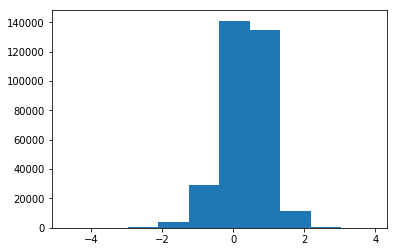

In [10]:
plt.hist(np.log10(distance_list.detach().numpy()))

# Differential Expression
From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

### Set population A and population B for comparison

In [11]:
cell_types = np.array(['astrocytes_ependymal', 'endothelial-mural', 'interneurons', 'microglia',
                       'oligodendrocytes', 'pyramidal CA1', 'pyramidal SS'], dtype=np.str)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))



Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



### Define parameters
* __M_sampling__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [12]:
M_sampling=100 
M_permutation=100000
permutation=False

### Sampling from the gene expression level from all cells
Note: The expectation of the ZINB distribution __px_rate ~ library_size * px_scale__, so __px_scale__ could be understood as the mean gene expression level of each cell after adjusting for the library size factor. 

In [13]:
px_scales = []
all_labels = []
for tensors in data_loader_train:
    if vae.use_cuda:
        tensors = to_cuda(tensors)
    sample_batch, _, _, batch_index, labels = tensors
    sample_batch = sample_batch.type(torch.float32)
    sample_batch = sample_batch.repeat(1, M_sampling).view(-1, sample_batch.size(1))
    batch_index = batch_index.repeat(1, M_sampling).view(-1, 1)
    labels = labels.repeat(1, M_sampling).view(-1, 1)
    px_scales += [vae.get_sample_scale(sample_batch, y=labels, batch_index=batch_index)]
    all_labels += [labels]

px_scale = torch.cat(px_scales)
all_labels = torch.cat(all_labels)

### Extracting the sampled gene expression level for the two populations of interest, and creating indexes for the samples

In [14]:
sample_rate_a = px_scale[all_labels.view(-1) == couple_celltypes[0]].view(-1, px_scale.size(1)).cpu().detach().numpy()
sample_rate_b = px_scale[all_labels.view(-1) == couple_celltypes[1]].view(-1, px_scale.size(1)).cpu().detach().numpy()

list_1 = list(np.arange(sample_rate_a.shape[0]))
list_2 = list(sample_rate_a.shape[0] + np.arange(sample_rate_b.shape[0]))

samples = np.vstack((sample_rate_a, sample_rate_b))

### Computing whether a gene is differentially expressed by computing pairs of cells from population A and population B

In [15]:
u, v = np.random.choice(list_1, size=M_permutation), np.random.choice(list_2, size=M_permutation)
first_set = samples[u]
second_set = samples[v]
res1 = np.mean(first_set >= second_set, 0)
res1 = np.log(res1 + 1e-8) - np.log(1 - res1 + 1e-8)


### Obtaining the null value by comparing pairs sampled from the combined population

In [16]:
u, v = (np.random.choice(list_1 + list_2, size=M_permutation),
    np.random.choice(list_1 + list_2, size=M_permutation))
first_set = samples[u]
second_set = samples[v]
res2 = np.mean(first_set >= second_set, 0)
res2 = np.log(res2 + 1e-8) - np.log(1 - res2 + 1e-8)


### Printing out the differential expression value from both the true comparison and the permuted comparison

In [17]:
genes_of_interest = ["Thy1", "Mbp"]
gene_names = data_loader_train.dataset.gene_names
result = [(gene_name, res1[np.where(gene_names == gene_name.upper())[0]][0],res2[np.where(gene_names == gene_name.upper())[0]][0]) for gene_name in genes_of_interest]
print('\n'.join([gene_name + " : " + str(r1) + " , "+ str(r2) for (gene_name, r1,r2) in result]))


Thy1 : -5.277349111874797 , -0.007760038785864287
Mbp : 5.412648774259256 , 0.014360246484573014


### Plotting the Null distribution of the DE values

(array([ 23.,  52., 123., 107.,  81.,  50.,  51.,  38.,  22.,  11.]),
 array([-0.01968063, -0.01589252, -0.01210441, -0.00831629, -0.00452818,
        -0.00074007,  0.00304805,  0.00683616,  0.01062427,  0.01441239,
         0.0182005 ]),
 <a list of 10 Patch objects>)

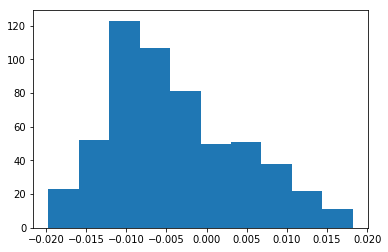

In [18]:
plt.hist(res2)

In [19]:
os.getcwd()

'/home/ec2-user/scVI'

# Correction for batch effects

In [20]:
gene_dataset = RetinaDataset()

Finished preprocessing Retina dataset
Finished preprocessing dataset


In [21]:
n_epochs=500
lr=1e-3
use_batches=True
use_cuda=True

### Train the model and output model likelihood every 5 epochs

example_indices = np.random.permutation(len(gene_dataset))
tt_split = int(0.9 * len(gene_dataset))  # 90%/10% train/test split

data_loader_train = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                               sampler=SubsetRandomSampler(example_indices[:tt_split]),
                               collate_fn=gene_dataset.collate_fn)
data_loader_test = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,
                              sampler=SubsetRandomSampler(example_indices[tt_split:]),
                              collate_fn=gene_dataset.collate_fn)
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches, n_labels=gene_dataset.n_labels,
            use_cuda=use_cuda)
stats = train(vae, data_loader_train, data_loader_test, n_epochs=n_epochs, lr=lr, benchmark=False)



Total runtime for 500 epochs is: 2065.997932434082 seconds for a mean per epoch runtime of 4.1319958648681645 seconds.


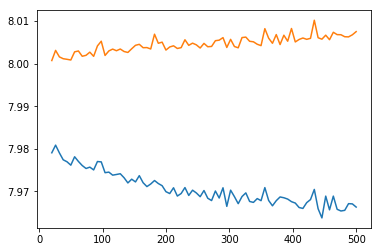

In [22]:

# Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error. 

LL_train = stats.history["LL_train"]
LL_test = stats.history["LL_test"]
x = np.linspace(20,500,(len(LL_train)-19))
plt.plot(x, np.log(LL_train)[19:500])
plt.plot(x, np.log(LL_test)[19:500])
plt.show()



In [23]:
# obtaining latent space in the same order as the input data

data_loader = DataLoader(gene_dataset, batch_size=128, pin_memory=use_cuda,shuffle=False,collate_fn = gene_dataset.collate_fn)
latent, batch_indices, labels = get_latent(vae,data_loader)


## Computing batch mixing 

In [25]:
print("Entropy batch mixing :", entropy_batch_mixing(latent, batch_indices))

Entropy batch mixing : 0.6610394948076351


### Coloring by batch

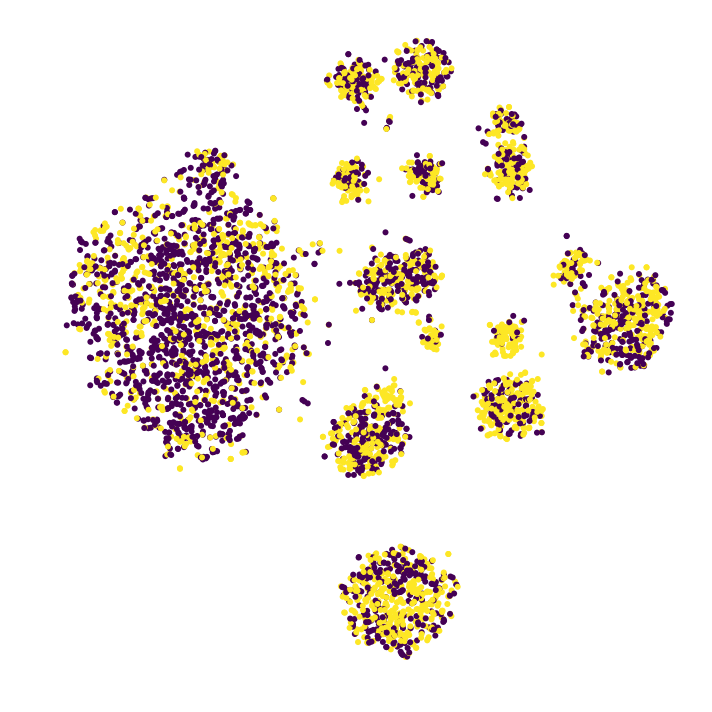

In [26]:
sample = np.random.permutation(len(latent))[range(5000)]
latent = latent[sample,:]
data_batch = np.concatenate(gene_dataset.batch_indices[sample])

if latent.shape[1] != 2:
    latent = TSNE().fit_transform(latent)

plt.figure(figsize=(10, 10))
plt.scatter(latent[:, 0], latent[:, 1], c=data_batch, edgecolors='none')
# plt.title(title)
plt.axis("off")
plt.tight_layout()
plt.show()

### Coloring by cluster id

In [27]:
labels = labels[sample]

No handles with labels found to put in legend.


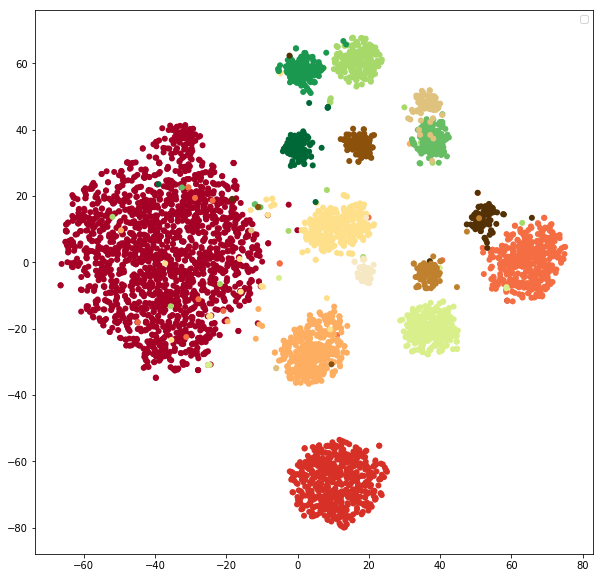

In [28]:
colors = ['#a50026','#d73027','#f46d43','#fdae61','#fee08b','#d9ef8b','#a6d96a','#66bd63','#1a9850','#006837','#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(len(colors)):
    ax.scatter(latent[labels==i,0], latent[labels==i,1], c=colors[i],  edgecolors='none')

ax.legend()

plt.show()